# Governments have been largely effective in coping with the COVID-19 pandemic: An investigation of governmental measures taken to combat health and economic crises

## Submission for Fundamentals of Social Data Science

### 09.12.2020

## Candidate number: 1051177

### Word Count: 3466

# Part 1 Introduction

The COVID-19 pandemic has an unprecedented effect on social life in the 21st century. Coronaviruses typically spread from person to person when an infected person coughs or sneezes. Hence, the suggested measures for preventing the spread of COVID-19 by the [World Health Organization](https://www.who.int/health-topics/coronavirus#tab=tab_1) focus on social distancing (Health Topics 2020). In line with that, governments around the world have implemented stringency measures aimed at reducing the spread of COVID-19. Among those measures are school and workplace closures, cancellation of public events, restrictions on gatherings, stay-at-home requirements, and restrictions on travel.  Independently, activities have been identified as low, medium or high risk in terms of spreading COVID-19 according to [500+ epidemiologists & health professionals](https://informationisbeautiful.net/visualizations/covid-19-coronavirus-infographic-datapack/) (Coronavirus Riskiest Activities 2020).  Low risk activities can generally be characterized as either outdoor activities or essential gatherings of small groups, such as visiting a doctor or grocery shopping. Medium risk activities include indoor sports, taking public transport, and having small unessential gatherings. High risk activities include large unessential gatherings and meeting up with someone you do not know well. 
 
Following from the above, this paper asks the following research question:
 
> $RQ_1$: Do the restrictions put in place by governments lead to a reduction in risky activities regarding the spread of COVID-19?

In particular, the paper hypothesizes ($H_1$) that the government stringency measures have a significant effect on organized events, such as schools and workplaces, but less so on unorganized events, such as walks in a park or outdoor sports. To investigate ($H_1$) the paper uses the OxCOVID-19 Database to study the government measures put in place by the German government and relates this data to mobility data captured by Google Maps in several categories (Mahdi et. al 2020). The aim is to identify whether higher restrictions put in place by the German government reduce mobility in categories which feature typically medium and high-risk activities. Germany has been chosen because (1) the government implemented varied strengths of restrictions over time and (2) generates mobility data in all categories measured.
 
To answer its research question, this report utilizes the government response, mobility and weather data of the OxCOVID-19 Database. To measure the government response, this report uses the stringency index within the government response data, an index made up of variables that capture the effort to enforce social distancing at school, workplace, transport, and social gatherings. To measure mobility data, the paper utilizes Google Maps data aggregated for Germany as a whole. To identify the effect of government stringency measures on mobility data, the paper (1) correlates the stringency index with mobility in each category, (2) implements a best subset selection on a linear regression model to identify the best linear regression model that contains a given number of predictors, where best is quantified using the test error, and (3) plot relevant relationships. During (2), weather data will be used to introduce additional independent variables, which will prove useful in identifying the relationship between the stringency index and mobility in parks. This process enables the paper to identify which categories of mobility data are significantly affected by government stringency measures in order to subsequently analyze the particularities of the relationships between them. Finally, the paper creates a rolling average of both, the stringency index and the mobility data, to smoothen the effects of weekends and public holidays on mobility.

# Part 1 Data Analysis

## Import functions

In [40]:
import numpy as np
import pandas as pd

from datetime import datetime
from functools import reduce
import re

import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.image as mpimg

import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools

import psycopg2 # requires following command to install -> pip install psycopg2-binary
import requests

# setting default option to display all columns in dataframe
pd.set_option('display.max_columns', None)

## Helper functions

In [3]:
def substract_cal(x):
    return x - 273.14

def fit_subset(feature_set,i):
    # fit model on feature_set and calculate test error
    model = sm.OLS(data_cat[i][0],X_train[list(feature_set)])
    regr = model.fit()
    test_error = ((regr.predict(X_test[list(feature_set)]) - data_cat[i][1]) ** 2).sum()
    return {"model":regr, "test_error": test_error}

def best_model(k,i):
    # takes number of features k and after fitting all possible combinations of k feature models to data,
    # outputs the model with the lowest test set error
    results = []
    for combination in itertools.combinations(X_train.columns, k):
        results.append(fit_subset(combination,i))
    # wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    # choose the model with the highest RSS
    best_model = models.loc[models['test_error'].argmin()]
    return best_model

def get_cumulated_array(data, **kwargs):
    cum = data.clip(**kwargs)
    cum = np.cumsum(cum, axis=0)
    d = np.zeros(np.shape(data))
    d[1:] = cum[:-1]
    return d  

## Data loading

In [4]:
# loading the government response data and transforming it into a dataframe
CSV_URL_GOVTRACK = 'https://media.githubusercontent.com/media/covid19db/data/master/data-government-response/covid19db-government-response-GOVTRACK.csv'

req_govtrack = requests.get(CSV_URL_GOVTRACK)
url_content_govtrack = req_govtrack.content
csv_file_govtrack = open('covid19db-government-response-GOVTRACK.csv', 'wb')

csv_file_govtrack.write(url_content_govtrack)
csv_file_govtrack.close()

df_govtrack_raw = pd.read_csv('covid19db-government-response-GOVTRACK.csv')


# loading the mobility data and transforming it into a dataframe
CSV_URL_MOBILITY = 'https://media.githubusercontent.com/media/covid19db/data/master/data-mobility/covid19db-mobility-GOOGLE_MOBILITY.csv'

req_mobility = requests.get(CSV_URL_MOBILITY)
url_content_mobility = req_mobility.content
csv_file_mobility = open('covid19db-mobility-GOOGLE_MOBILITY.csv', 'wb')

csv_file_mobility.write(url_content_mobility)
csv_file_mobility.close()

df_mobility_raw = pd.read_csv('covid19db-mobility-GOOGLE_MOBILITY.csv')

# loading the weather data and transforming it into a dataframe
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19')
cur = conn.cursor()

countrycode = "DEU"

sql_command = """SELECT * FROM weather WHERE countrycode=%(countrycode)s ORDER by date DESC"""
df_weather_raw = pd.read_sql(sql_command, conn, params={'countrycode': countrycode})

## Data cleaning and variable setup

In [5]:
# cleaning government response dataframe
col_date = ["date"]

for i in col_date: 
    df_govtrack_raw["f_{}".format(i)] = df_govtrack_raw[i].map(
        lambda datetext: datetime.strptime(datetext, 
                                           '%d-%m-%Y'))

df_govtrack_clean = df_govtrack_raw[df_govtrack_raw["country"]=="Germany"]
    
col_govtrack = ['stringency_index',
                'government_response_index',
                'containment_health_index',
                'economic_support_index',
                'f_date']

df_govtrack_clean = df_govtrack_clean[col_govtrack]
df_govtrack_clean.set_index('f_date',inplace=True)

# creating government response dataframe by week
df_govtrack_clean.reset_index(inplace=True)
df_govtrack_clean['f_date'] = pd.to_datetime(df_govtrack_clean['f_date']) - pd.to_timedelta(7, unit='d')
df_govtrack_clean_week = df_govtrack_clean.groupby(pd.Grouper(key='f_date', freq='1W'))[col_govtrack].mean()
df_govtrack_clean.set_index("f_date",inplace=True)



# cleaning mobility dataframe
col_mobility = ['transit_stations',
                'residential',
                'workplace',
                'parks',
                'retail_recreation',
                'grocery_pharmacy',
                'f_date']

for i in col_date: 
    df_mobility_raw["f_{}".format(i)] = df_mobility_raw[i].map(
        lambda datetext: datetime.strptime(datetext, 
                                           '%d-%m-%Y'))
    
df_mobility_clean = df_mobility_raw[df_mobility_raw["country"]=="Germany"]
    
df_mobility_clean = df_mobility_clean.groupby(df_mobility_clean["f_date"].dt.date)[['transit_stations',
                                                                                    'residential',
                                                                                    'workplace',
                                                                                    'parks',
                                                                                    'retail_recreation',
                                                                                    'grocery_pharmacy',
                                                                                    'f_date']].mean()

# creating mobility dataframe by week
df_mobility_clean.reset_index(inplace=True)
df_mobility_clean['f_date'] = pd.to_datetime(df_mobility_clean['f_date']) - pd.to_timedelta(7, unit='d')
df_mobility_clean_week = df_mobility_clean.groupby(pd.Grouper(key='f_date', freq='1W'))[col_mobility].mean()
df_mobility_clean['f_date'] = pd.to_datetime(df_mobility_clean['f_date']) + pd.to_timedelta(7, unit='d') # correcting for shift in f_date
df_mobility_clean = df_mobility_clean.set_index('f_date')



# cleaning weather dataframe
for i in col_date:
    df_weather_raw['datestr'] = df_weather_raw[i].map(lambda datetext: str(datetext))
    
col_datestr = ["datestr"]

for i in col_datestr: 
    df_weather_raw["f_{}".format(i)] = df_weather_raw[i].map(
        lambda datetext: datetime.strptime(datetext, 
                                           '%Y-%m-%d'))

df_weather_clean = df_weather_raw.groupby([df_weather_raw["f_datestr"].dt.date])[["precipitation_mean_avg",
                                                                                  "temperature_mean_avg",
                                                                                  "windspeed_mean_avg",
                                                                                  "cloudaltitude_mean_avg",
                                                                                  "cloudfrac_mean_avg"]].mean()
df_weather_clean["temperature_mean_avg"] = df_weather_clean["temperature_mean_avg"].apply(substract_cal)

##########################################################

# merging dataframes
mergeFrame_light = df_govtrack_clean.merge(df_mobility_clean,left_index=True,right_index=True, how='inner')
mergeFrame_1 = mergeFrame_light.merge(df_weather_clean,left_index=True,right_index=True,how='inner')

# merging week dataframes
mergeFrame_week = df_govtrack_clean_week.merge(df_mobility_clean_week,left_index=True,right_index=True, how='inner')

##########################################################

# creating variables
Months_1 = ["February",
          "March",
          "April",
          "May",
          "June",
          "July",
          "August",
          "September",
          "October",
          "November",
          "December"]

Months_2 = ["March",
            "April",
            "May",
            "June",
            "July",
            "August",
            "September",
            "October",
            "November",
            "December"]

parameter_index_list = ['transit_stations', 
                     'workplace', 
                     'retail_recreation', 
                     'grocery_pharmacy', 
                     'parks', 
                     'residential']

parameter_list = ["Parks", 
                  "Grocery and Pharmacy",
                  "Residential","Workplace",
                  "Retail and Recreation",
                  "Transit Stations"]

categories = ["Transit Stations", 
              "Workplace", 
              "Retail and Recreation", 
              "Residential"]

parameter_dict = {"transit_stations":["Transit"],
                  "residential":["Residential"],
                  "workplace":["Workplace"],
                  "parks":["Parks"],
                  "retail_recreation":["Retail and Recreation"],
                  "grocery_pharmacy":["Grocery and Pharmacy"]}

stringency = pd.DataFrame(mergeFrame_1.loc[:,"stringency_index"])
economics = pd.DataFrame(mergeFrame_1.loc[:,"economic_support_index"])
government = pd.DataFrame(mergeFrame_1.loc[:,"government_response_index"])
containment = pd.DataFrame(mergeFrame_1.loc[:,"containment_health_index"])

y_1 = mergeFrame_1.iloc[:,4:10]
x_1 = mergeFrame_1.index

y_week = mergeFrame_week.iloc[:,4:10]
x_week = mergeFrame_week.index

transit_stations = y_1.iloc[:,0]
residential = y_1.iloc[:,1]
workplace = y_1.iloc[:,2]
retail_recreation = y_1.iloc[:,4]
grocery_pharmacy = y_1.iloc[:,5]

transit_stations_week = y_week.iloc[:,0]
residential_week = y_week.iloc[:,1]
workplace_week = y_week.iloc[:,2]
retail_recreation_week = y_week.iloc[:,4]
grocery_pharmacy_week = y_week.iloc[:,5]

data = np.array([transit_stations, workplace, retail_recreation, residential])
data_week = np.array([transit_stations_week, workplace_week, retail_recreation_week, residential_week])

## Data analysis

In [6]:
# creating correlation matrix
corr_df = stringency.merge(y_1,left_index=True,right_index=True,how='inner')

corr = corr_df.corr()
# Generate a mask for the upper triangle
mask_corr = np.zeros_like(corr, dtype=np.bool)
mask_corr[np.triu_indices_from(mask_corr)] = True

##########################################################

# best subset selection
np.seed = 200000

# splitting data into training and testing data
mask = np.random.rand(len(mergeFrame_1)) < 0.667
train = mergeFrame_1[mask]
train = train.dropna()
test = mergeFrame_1[~mask]
test = test.dropna()

X_train = train.loc[:,train.columns[~train.columns.isin(parameter_index_list)]]
X_test = test.loc[:,test.columns[~test.columns.isin(parameter_index_list)]]

y_train_parks = train.loc[:,'parks']
y_test_parks = test.loc[:,'parks']

y_train_grocery = train.loc[:,'grocery_pharmacy']
y_test_grocery = test.loc[:,'grocery_pharmacy']

y_train_residential = train.loc[:,'residential']
y_test_residential = test.loc[:,'residential']

y_train_work = train.loc[:,'workplace']
y_test_work = test.loc[:,'workplace']

y_train_retail_recreation = train.loc[:,'retail_recreation']
y_test_retail_recreation = test.loc[:,'retail_recreation']

y_train_transit_stations = train.loc[:,'transit_stations']
y_test_transit_stations = test.loc[:,'transit_stations']

data_cat = [[y_train_parks,y_test_parks],
            [y_train_grocery,y_test_grocery],
            [y_train_residential,y_test_residential],
            [y_train_work,y_test_work],
            [y_train_retail_recreation,y_test_retail_recreation],
            [y_train_transit_stations,y_test_transit_stations]]

# selecting the best model for each k number of parameters using a for loop
models_best = pd.DataFrame(columns=["test_error", "model", "Dependent Variable", "# Parameters"])

para_list = []
para_num_list = []

for val,cat in enumerate(parameter_list):
    for i in range(1,4):
        models_best = models_best.append(best_model(i,val))
        para_list.append(cat)
        para_num_list.append(i)
        
models_best["Dependent Variable"] = para_list
models_best["# Parameters"] = para_num_list

# adding descriptive statistics to the best subset selected linear regresison models
params = []
rsquared = []

for i in range(len(models_best)):
    params.append(str(models_best.iloc[i, 1].params[:].index))
    rsquared.append(models_best.iloc[i, 1].rsquared)
    
models_best["Parameters"] = params
models_best["R-squared"] = rsquared

# cleaning the resulting dataframe
reg01 = re.compile("\[[^\[\]]+\]")
reg02 = re.compile("[\w_]+")

model_para_list = []
model_para = []

for i in range(len(models_best)):
    model_para_list.append(reg01.findall(models_best.iloc[i,-2]))
    
for i in range(len(models_best)):
    model_para.append(reg02.findall(model_para_list[i][0]))
    
models_best["Parameters"] = model_para

models_best = models_best.explode('Parameters')
models_best = models_best.reset_index(drop=True)
models_best = models_best.drop(['test_error','model'],axis=1)
models_best = models_best.set_index('Dependent Variable')

## Plotting relationships

In [23]:
# print("\n\n\n\n\n\n")

def figure_1():
    # overview of stringency index over time
    figure1, ax = plt.subplots(figsize=(18,5))

    plt.bar(mergeFrame_week.index,mergeFrame_week['stringency_index'],width=5)
    # plt.ylim(30,80)
    plt.ylabel('Stringency Index (out of 100)',fontsize=15)
    plt.xlabel('Months',fontsize=15)
    plt.title('Figure 1: Stringency index plotted over time',ha='center',fontsize=20)

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    ax.set_xticklabels(Months_1, fontsize=10)

    plt.show()
    # figure1.savefig('figure1.pdf')
#     plt.close()
    # print("\n\n\n\n\n\n\n\n")

##########################################################

# drawing from code from: 
# https://stackoverflow.com/questions/49237522/how-to-annotate-end-of-lines-using-python-and-matplotlib

def figure_2():
    # plotting mobility over time per category
    plt.rcParams["figure.figsize"] = [20,10]
    ax = y_week.plot(legend=None)
    ax.set_title("Figure 2: Mobility during Corona",fontsize=20)
    plt.xlabel("Months",fontsize=15)
    plt.ylabel("Mobility (%)",fontsize=15)

    for line, name in zip(ax.lines, y_week.columns.to_list()):
        yy = line.get_ydata()[-1]
        if name == 'residential' : yy = yy + 2
        if name == 'transit_stations' : yy = yy - 3
        if name == 'retail_recreation': yy = yy - 1
        if name == 'workplace' : yy = yy + 2    
        ax.annotate(name, xy=(1,yy), xytext=(6,0), color=line.get_color(), 
                    xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                    size=14, va="center")

#     plt.savefig('figure2.pdf')
    plt.show()
#     plt.close()
    # print("\n\n\n\n\n\n\n\n")

##########################################################

def figure_3():
    # creating correlation matrix
    figure3, ax = plt.subplots(figsize=(12, 12))
    plt.title('Figure 3: Correlation matrix for stringency index and mobility per category',
              ha='center',va='baseline',fontsize=20)
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    # drawing heatmap of correlations between stringency index and mobility per category
    sns.heatmap(corr, vmin=-1, vmax=1, mask=mask_corr, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True);

    plt.show()
    # figure3.savefig('figure3.pdf')
#     plt.close()
    # print("\n\n\n\n\n\n\n\n")

##########################################################

def figure_4():
    # zooming in to relationship between stringency index and mobility in parks
    figure4, (ax1, ax2) = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(15,5))
    figure4.subplots_adjust(left=0.08, right=0.92, wspace=0.2)
    plt.suptitle('Figure 4: Relationship between stringency index and mobility in parks',ha='center',y=0.95,fontsize=20)

    sns.regplot(x=mergeFrame_1["temperature_mean_avg"],y=mergeFrame_1["parks"],color="g", ax=ax1)
    ax1.set_xlabel('Temperature',fontsize=15)
    ax1.set_ylabel('Mobility in Parks (%)',fontsize=15)

    sns.regplot(x=mergeFrame_1["stringency_index"],y=mergeFrame_1["parks"],color="g", x_jitter=2, ax=ax2)
    ax2.set_xlabel('Stringency Index',fontsize=15)
    ax2.set_ylabel('Mobility in Parks (%)',fontsize=15);

    plt.show()
    # figure4.savefig('figure4.pdf')
#     plt.close()
    # print("\n\n\n\n\n\n\n\n")  

##########################################################

def figure_5():
    # zooming in to relationship between stringency index and mobility in groceries and pharmacies
    figure5, ax1 = plt.subplots(ncols=1, sharex=False, sharey=False, figsize=(15,5))
    figure5.subplots_adjust(left=0.08, right=0.92, wspace=0.2)
    plt.title('Figure 5: Relationship between stringency index and mobility in groceries and pharmacies',
              ha='center',va='baseline',fontsize=20)

    sns.regplot(x=mergeFrame_1["stringency_index"],y=mergeFrame_1["grocery_pharmacy"],color="g", x_jitter=2, ax=ax1)
    ax1.set_xlabel('Stringency Index',fontsize=15)
    ax1.set_ylabel('Mobility in Grocery and Pharmacy (%)',fontsize=15);

    plt.show()
    # figure5.savefig('figure5.pdf')
#     plt.close()
    # print("\n\n\n\n\n\n\n\n")  

##########################################################

# drawing on code from:
# https://stackoverflow.com/questions/35979852/stacked-bar-charts-using-python-matplotlib-for-positive-and-negative-values

def figure_6():
    # overview of selected categories of mobility over time
    data_shape = np.shape(data_week)

    dates = []
    for i in np.arange(0,len(x_week),9):
        dates.append(x_week[i].month_name())

    cumulated_data = get_cumulated_array(data_week, min=0)
    cumulated_data_neg = get_cumulated_array(data_week, max=0)

    # Re-merge negative and positive data.
    row_mask = (data_week<0)
    cumulated_data[row_mask] = cumulated_data_neg[row_mask]
    data_stack = cumulated_data

    figure6 = plt.figure(figsize=(15,10))

    ax = plt.subplot(111)
    ax.set_title('Figure 6: Mobility over time relative to January/February levels (subdivided into categories)',
                 ha='center',va='baseline',fontsize=20)
    ax.set_xticks(np.arange(0,len(x_week),9))
    ax.set_xticklabels(dates,fontsize=12)

    plt.xlabel("Months",fontsize=15)
    plt.ylabel("Mobility Change (%)",fontsize=15)

    for i in np.arange(0, data_shape[0]):
        ax.bar(np.arange(data_shape[1]), data_week[i], bottom=data_stack[i],label=categories[i])
        ax.legend()

    plt.show()
    # figure6.savefig('figure6.pdf')
#     plt.close()
    # print("\n\n\n\n\n\n\n\n")

##########################################################

# plotting subplots for each category of mobility and stringency index
roll = 14

stringency_roll = pd.DataFrame(mergeFrame_1.loc[:,"stringency_index"].rolling(roll, center=True).mean())

y_roll = mergeFrame_1.iloc[:,4:10].rolling(roll, center=True).mean()

transit_stations_roll = y_roll.iloc[:,0]
residential_roll = y_roll.iloc[:,1]
workplace_roll = y_roll.iloc[:,2]
retail_recreation_roll = y_roll.iloc[:,4]

data_roll = [transit_stations_roll, workplace_roll, retail_recreation_roll, residential_roll]

def figure_7():
    figure7, axs = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(15,12))
    figure7.subplots_adjust(left=0.08, right=0.92, wspace=0.1)
    figure7.text(0.5, 0.13, 'Months', ha='center', va='center', fontsize=15)
    figure7.text(0.03, 0.53, 'Mobility (%)', ha='center', va='center', rotation='vertical', fontsize=15)
    figure7.text(0.97, 0.53, 'Stringency Index', ha='center', va='center', rotation=270, fontsize=15)
    figure7.autofmt_xdate()
    figure7.suptitle("Figure 7: Mobility per category plotted against stringency index", fontsize=20,y=0.95) 

    axes = [[0],[1],[2],[3]]
    for val,cat in enumerate(categories):
        ax = axs[axes[val][0]]
        ax.plot(x_1, data_roll[val],label=cat)
        ax.legend(loc=1)
        ax.set_title(cat)
        ax_stringency = ax.twinx()
        ax_stringency.plot(x_1,stringency_roll,color='red',label='Stringency Index')
        ax_stringency.legend(loc=4)

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    ax.set_xticklabels(Months_2, fontsize=10)


    plt.show()
    # figure7.savefig('figure7.pdf')
#     plt.close()
    # print("\n\n\n\n\n\n\n\n")

# Part 1 Results

Before reporting on the relationship between the stringency index and mobility data, this paper briefly runs through some univariate descriptions of the data involved.

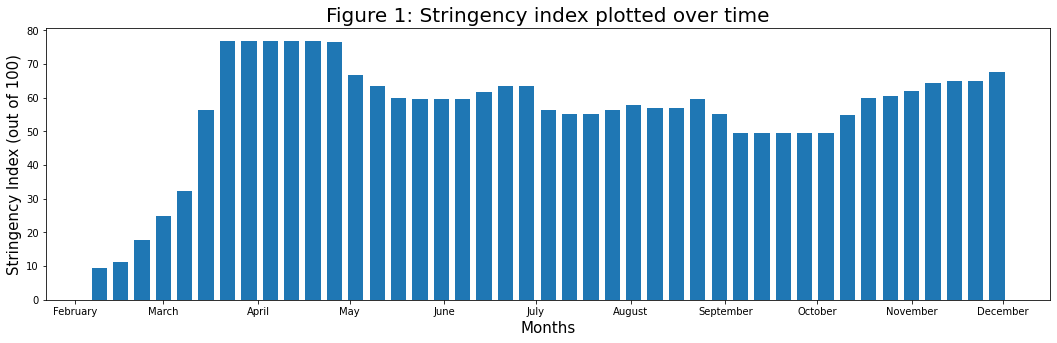

In [24]:
figure_1()

Figure 1 depicts the stringency index from February to December 2020. One can see that the German government implemented a “lockdown” from March into late April. This entailed school and workplace closures, travel restrictions, restriction on gatherings and stay-at-home requirements. As time passed, the German government eased some measures, notably reopening schools and workplaces as well as recreational sites. Nevertheless, by October, the government reversed course due to increased infection rates and tightened restrictions again.

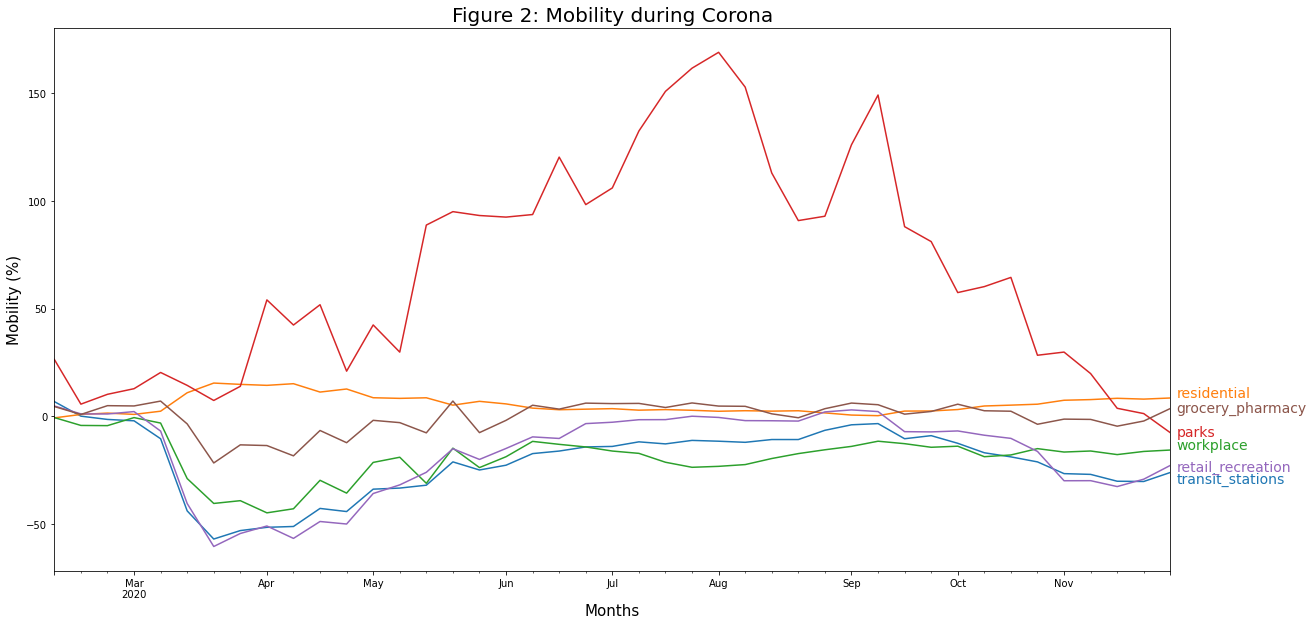

In [25]:
figure_2()

Figure 2 presents mobility data split into categories. The data is relative to the mobility in each category during a 5-week period from the beginning of January to the beginning of February. One can see that during March, mobility in retail, transit and the workplace dropped by half, while mobility in groceries and pharmacies dropped, but less so. Further, two mobility categories increased. Residential activity increased slightly during March and slowly decreased to the baseline level in July. Parks saw a dramatic 150% increase in mobility in summer before reversing to its baseline level in December. 

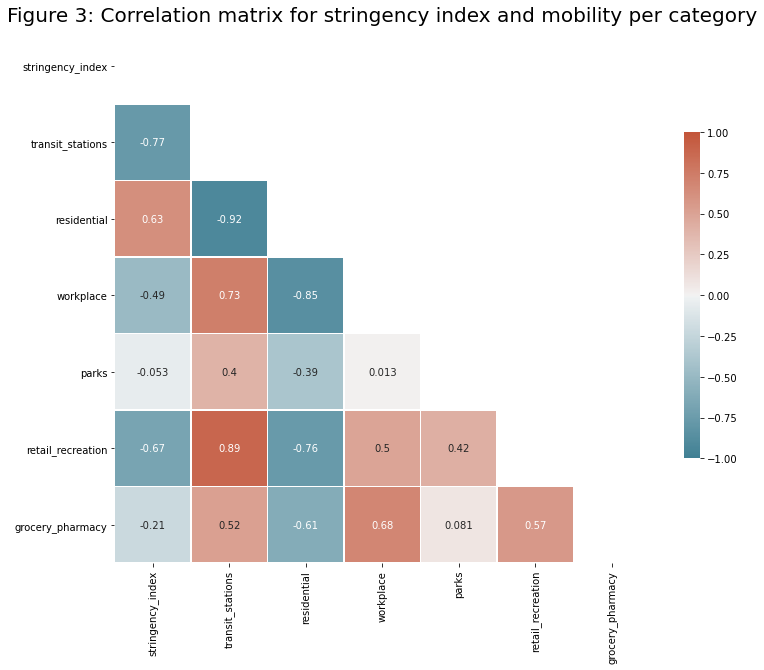

In [26]:
figure_3()

To identify what is the effect of the stringency index on mobility, it is crucial to create multivariate descriptive statistics. Figure 3 depicts a correlation matrix where the first column identifies the correlation between the stringency index and mobility in each category. One can see that correlations are relatively strong between the stringency index and mobility in transit stations, residential areas, workplaces, and retail and recreation. Groceries and pharmacies show only a weak correlation to the stringency index and parks show no correlation.

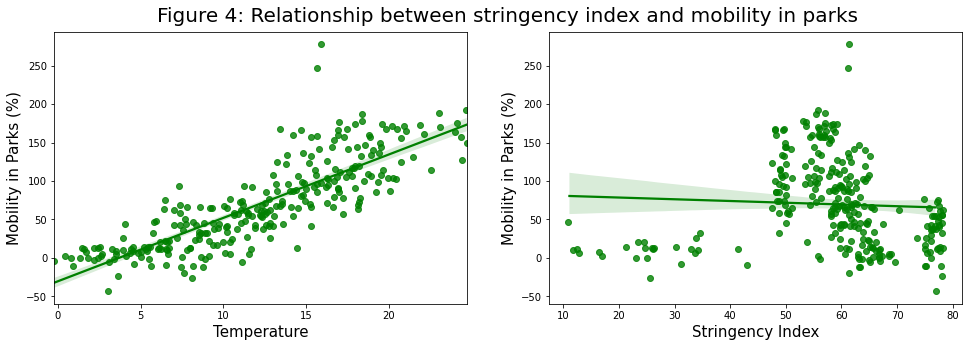

In [27]:
figure_4()

Following from Figure 3, this report investigates the relationship between the stringency index and mobility in parks as well as groceries and pharmacies. Figure 4 plots mobility in parks against average temperatures and the stringency index. The result is a strong positive relationship between mobility in parks and average temperatures and no relationship between mobility in parks and the stringency index. This is plausible, because rainy and stormy days (which are correlated with lower average temperatures), or just a cold day, offer less opportunity to enjoy time outdoors. As a result of the strong confounding factor of weather conditions, mobility in parks has been dropped from further analysis without a clear conclusion about whether government stringency measures affect mobility within it.

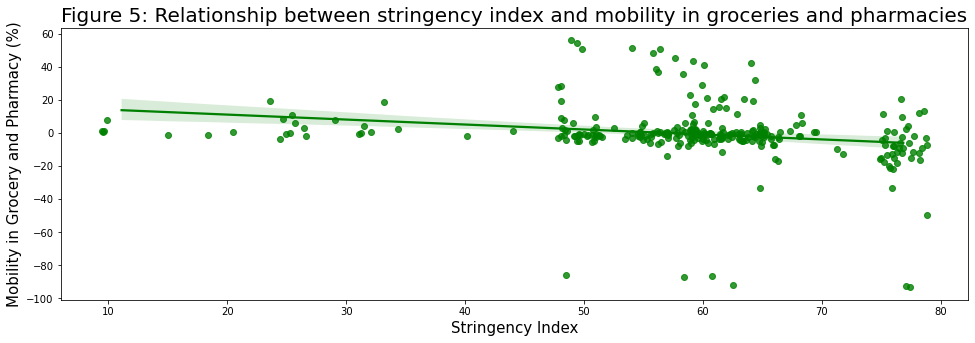

In [28]:
figure_5()

When looking at mobility in groceries and pharmacies in Figure 5, one can see a slightly negative relationship, where stricter government measures lead to less mobility in groceries and pharmacies. Nevertheless, mobility in groceries and pharmacies has been dropped from further analysis as going for groceries and pharmacies has been largely exempted from government restriction because they are an essential part of people’s lives. Additionally, although online groceries and pharmacies are on the rise, the bulk of shopping is still done [offline](https://www.statista.com/statistics/993637/market-share-online-trade-food-sales-germany/) (HDE 2020). Thus, government restrictions are unlikely to have affected mobility in groceries and pharmacies significantly. 

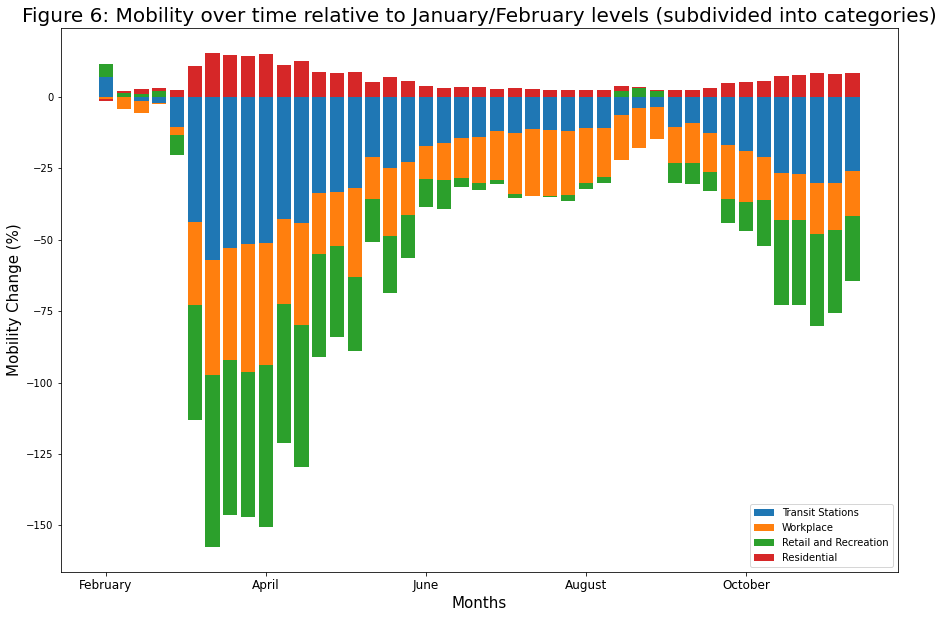

In [29]:
figure_6()

The above results are further supported by Table 1 (in Appendix). Table 1 summarizes the results of a best subset selection by identifying the best linear regression model that contains a given number of predictors. It lists the number of parameters in each model and, for that given model lists the particular parameters that make up the most accurate linear regression and its corresponding R-squared value. When looking at mobility in parks and groceries and pharmacies, one can see that in both the stringency index does not feature any of the best models. In contrast, average temperatures can explain roughly 87% of the variation in mobility in parks, which strengthens the hypothesis that park visits are heavily dependent on weather conditions. Further, even after including three parameters, the explanatory power of the best model for groceries and pharmacies is only around 6%, suggesting that a lot of variation in mobility in groceries and pharmacies is due to random noise. Figure 6 (in Appendix) reports the overall changes in mobility for the remaining categories for the period between February and December 2020.

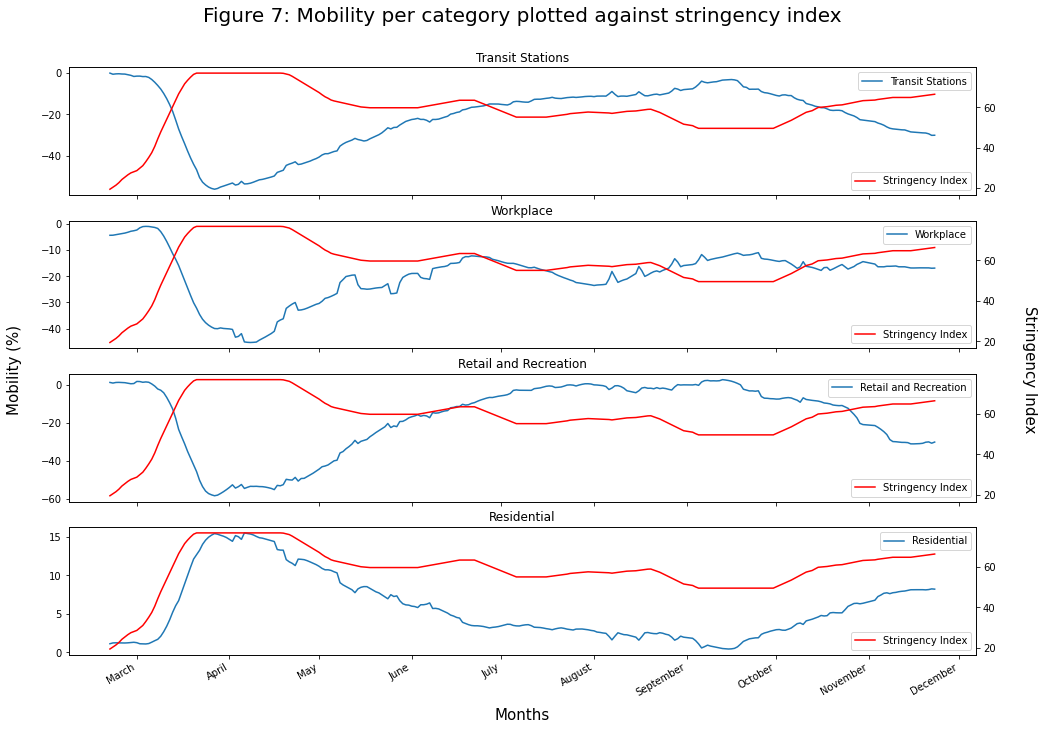

In [30]:
figure_7()

In the remainder of Part 1, the paper focuses on the remaining mobility categories plotted against the stringency index over time. In Figure 7, one can see the previously noted negative correlation between stringency index and mobility in transit stations, workplace and retail and recreation. All of those mobility categories have been heavily targeted by government stringency measures, through workplace closures as well as closures of unessential retail and recreation outlets. Naturally, people tend to reduce their consumption of public transport when there is no destination to travel to. Hence the negative relation between stringency index and mobility at transit stations could be a consequence of reduced mobility at workplaces and retail and recreation outlets. What is even more reason to believe that the government stringency measures worked as desired is that mobility in residential areas corresponds well with the stringency index. This is possibly due to stay-at-home requirements but also plausibly related to less options for leaving residential areas for a good reason, i.e., closure of workplaces and retail and recreation outlets.
 
In sum, this paper has shown that government stringency measures are a likely cause for reduced mobility in transit stations, workplaces and retail and recreation outlets, while increasing mobility in residential areas. Beyond these conclusions, mobility data about parks remains inconclusive while mobility trends in groceries and pharmacies are likely due to noise only. When relating these findings back to the initial motivation, of whether government stringency measures achieve the desired effect of reducing risky activities in relation to COVID-19, it should be noted that all the above mobility categories reduced by government stringency measures feature medium and high-risk activities. While working in a shared office is categorized as medium-risk, meeting someone you do not know well, which is categorized as high risk, is very likely to occur. Exercising recreational activities, such as visiting a bar, buffet or amusement park are all categorized as high-risk activities. Furthermore, all those activities can involve taking public transport, which is categorized as medium risk as well. Furthermore, activities related to mobility categories that are either unaffected by stringency measures or about which this report remains inconclusive feature activities that are, at most, of medium risk. Hence, this report concludes that the government stringency measures achieved their desired effect and reduced risky activities related to COVID-19.

# Part 1 Limitations

While the paper utilizes data beyond government stringency measures to account for changes in mobility across several categories, thus accounting for potential confounding factors that could bias the resulting conclusions, there remains one major limitation. The mobility data of the OxCOVID-19 Database is restricted to 2020 only. For example, a useful insight into the effect of stringency measures on mobility would be to see how this year’s mobility data compare to previous years. That would allow for a counterfactual against which the above hypotheses could be tested more accurately.

# Part 2 Introduction

The outbreak of the COVID-19 pandemic has far-reaching consequences beyond the spread of the disease itself. The pandemic caused a global recession, the first sign of which was the fall in stock market prices during the beginning of 2020. Subsequently, a number of general economic indicators rapidly deteriorated. One notable instance to name is the [Conference Board Leading Economic Index (LEI)](https://blog.commonwealth.com/independent-market-observer/a-closer-look-at-the-conference-board-leading-economic-index), featuring, among other things, the weekly hours worked in manufacturing, the average number of applications for unemployment insurance, and average consumer expectations for business conditions (Kitchings 2020). As a reaction to these developments, governments around the world announced policy programs for guided economic recovery, such as the [Coronavirus Aid, Relief and Economy Security Act (“CARES Act”)](https://www.imf.org/en/Topics/imf-and-covid19/Policy-Responses-to-COVID-19#U) in the United States (Policy Responses to COVID-19 2020). The “CARES Act” includes various types of economic relief for impacted individuals, businesses and industries. These programs were meant to [mitigate the negative effects](https://www.reedsmith.com/en/perspectives/2020/03/cares-act-overview) of the economic downturn on citizen’s lives (CARES Act Overview 2020). This naturally leads the paper to its research questions:
 
> $RQ_2$: What was the effect of economic support measures on economic performance during the COVID-19 pandemic?

In particular, did economic support measures generate their desired effect, i.e., did they positively affect their citizens’ livelihoods, or did they mostly affect economic performance measures aside those affecting individual livelihoods in the form of stock market performance? It is important to investigate both sides, as both affect political backing of such measures, thus determining its future utilization. The particular relationships this report investigates is whether the economic support measures positively affect economic indicators such as the LEI, thus likely gaining support for its policies, or whether the economic support measures mostly propped up the stock market, thus [likely generating political backlash](https://www.economist.com/leaders/2020/05/07/the-market-v-the-real-economy) (The market v the real economy 2020).
 
In its analysis, this paper will consult data sources from (1) the [Yahoo Finance API](https://rapidapi.com/apidojo/api/yahoo-finance1?endpoint=apiendpoint_aeccfc9c-66eb-4f4a-abf5-c14d952e09f6) to collect stock market data for almost every stock listed in the S&P 500 (Yahoo Finance API Documentation 2020), (2) the names and sector categories of each S&P 500 stock listed in the [Open Data repository](https://datahub.io/core/s-and-p-500-companies-financials) (S&P 500 Companies with Financial Information 2020), (3) the government response data from the OxCOVID-19 Database to collect data on the economic support measures of the United States government (Mahdi et. Al 2020), and (4) economic indicators such as the LEI from the [Trading Economics API](https://tradingeconomics.com/indicators) (Indicators 2020). The paper will focus on the effects identified in the United States due to widely available stock market and economic indicators data.
 
The paper’s analysis normalizes all economic indicators investigated (LEI, Unemployment Rate, Central Bank Balance Sheet, Disposable Personal Income) and stock data to depict changes from the 31st January 2020. Subsequently, the paper uses the Economic Support Index (ESI) from the OxCOVID-19 Database as its measure for economic support measures, and LEI and S&P 500 Performance as its main outcome variables to be investigated. Investigation will entail (1) plotting univariate distributions of all variables of the above, (2) relating those variables to each other visually as well as through selected Pearson correlation coefficients, and (3) zooming into more explanatory relationships via consideration of further economic indicators or stock market sector aggregation to pick up nuanced effects of economic support measures on real economic and stock market performance.

# Part 2 Data Analysis

## Import functions

In [8]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams

from datetime import datetime
from os import sep

import requests
import json 
from functools import partial, reduce  

from RAPIDAPIkeys import keys

## Helper functions

In [9]:
# downloading stock data
def fetchStockData(symbol):

  response = requests.get("https://apidojo-yahoo-finance-v1.p.rapidapi.com/market/get-charts?region=US&lang=en&symbol=" 
                          + symbol + "&interval=1d&range=1y",
    headers={
      "X-RapidAPI-Host": keys['RAPIDAPI_HOST'],
      "X-RapidAPI-Key": keys['RAPIDAPI_KEY'],
      "Content-Type": "application/json"
    }
  )

  return response.json()


# downloading stock market indices data
def fetchStockMarketCap(symbol):

  response = requests.get("https://apidojo-yahoo-finance-v1.p.rapidapi.com/stock/v2/get-statistics?region=US&lang=en&symbol=" 
                          + symbol,
    headers={
      "X-RapidAPI-Host": keys['RAPIDAPI_HOST'],
      "X-RapidAPI-Key": keys['RAPIDAPI_KEY'],
      "Content-Type": "application/json"
    }
  )

  return response.json()

## Data loading

In [10]:
# loading names of all stocks in S&P 500

CSV_URL_STOCKMARKET = 'https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents.csv'

req_stocks = requests.get(CSV_URL_STOCKMARKET)
url_content_stocks = req_stocks.content
csv_file_stocks = open('constituents.csv', 'wb')

csv_file_stocks.write(url_content_stocks)
csv_file_stocks.close()

df_stocks = pd.read_csv('constituents.csv') 

# adjusting stocks dataframe manually to remove stocks that are not available for the selected period via the API
df_stocks = df_stocks[df_stocks.Symbol != 'CARR']
df_stocks = df_stocks[df_stocks.Symbol != 'OTIS']
symbols = df_stocks['Symbol'].to_list()

##########################################################

# loading S&P 500 data

url = "https://apidojo-yahoo-finance-v1.p.rapidapi.com/market/get-charts"
querystring = {"symbol":"AAPL","interval":"1d","range":"1y","region":"US","comparisons":"^GSPC"}
headers = {
    'x-rapidapi-key': keys['RAPIDAPI_KEY'],
    'x-rapidapi-host': keys['RAPIDAPI_HOST']
    }
response_index = requests.request("GET", url, headers=headers, params=querystring)

temp_df = response_index.json()

for i,j in enumerate(temp_df['chart']['result'][0]['timestamp']):
    if j == 1580481000: # choosing normalization date
        GSPC_index = i

timestamp_index = temp_df['chart']['result'][0]['timestamp'] # retreiving timestamp data
symbol_index = temp_df['chart']['result'][0]['comparisons'][0]['symbol']
open_price_index = [x / temp_df['chart']['result'][0]['comparisons'][0]['open'][GSPC_index] \
                    for x in temp_df['chart']['result'][0]['comparisons'][0]['open']] # Retreiving open data
close_price_index = [x / temp_df['chart']['result'][0]['comparisons'][0]['open'][GSPC_index] \
                     for x in temp_df['chart']['result'][0]['comparisons'][0]['close']] # Retreiving close data

df_index = pd.DataFrame(list(zip([symbol_index]*len(open_price_index),open_price_index,close_price_index,
                                 timestamp_index)),columns = ['Symbol','Open Price','Close Price','Timestamp'])
df_index.Timestamp = df_index.Timestamp.apply(lambda x: datetime.fromtimestamp(x))
df_index.Timestamp = df_index.Timestamp.apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))

col_date = ['Timestamp']

for i in col_date: 
    df_index["Date"] = df_index[i].map(
        lambda datetext: datetime.strptime(datetext, 
                                           '%Y-%m-%d'))

df_index['Open Price: S&P500'] = df_index['Open Price']
df_index = df_index.drop(['Symbol','Open Price','Close Price','Timestamp'],axis=1)
df_index = df_index.set_index('Date')

##########################################################

# loading stock data for each stock within S&P 500 individually

temp_df2 = pd.DataFrame(columns=['Timestamp','Symbol','Open Price','Closing Price'])

for val,s in enumerate(symbols[:3]):
    retdata = fetchStockData(s)
    for i, j in enumerate(retdata['chart']['result'][0]['timestamp']):
        if j == 1580481000: # start date chosen
            index = i

for val,s in enumerate(symbols):
    try:
        retdata = fetchStockData(s)
        symbol = retdata['chart']['result'][0]['meta']['symbol']
        open_price = [x / retdata['chart']['result'][0]['indicators']['quote'][0]['open'][index] \
                      for x in retdata['chart']['result'][0]['indicators']['quote'][0]['open']]
        close_price = [x / retdata['chart']['result'][0]['indicators']['quote'][0]['open'][index] \
                       for x in retdata['chart']['result'][0]['indicators']['quote'][0]['close']]
        timestamp = retdata['chart']['result'][0]['timestamp']
        dic = {'Timestamp':timestamp,'Symbol':symbol,'Open Price':open_price,'Closing Price':close_price}
        temp_df2 = temp_df2.append(pd.DataFrame(dic))
    except Exception as e:
        pass
    
##########################################################

# loading market capitalisation dataframe for each stock of the S&P 500 individually

temp_df3 = pd.DataFrame(columns=['Symbol','Market Cap'])

for val,s in enumerate(symbols):
    try:
        retdata = fetchStockMarketCap(s)
        symbol = retdata['price']['symbol']
        marketCap = retdata['price']['marketCap']['raw'] 
        dic = {'Symbol':[symbol],'Market Cap':[marketCap]}
        temp_df3 = temp_df3.append(pd.DataFrame(dic))
    except Exception as e:
        pass

## Data cleaning and variable setup

In [11]:
# merging the stock dataframe and indexing it

mergeFrame = temp_df2.merge(df_stocks, left_on="Symbol", right_on="Symbol", how='left')
mergeFrame_marketcap = mergeFrame.merge(temp_df3,left_on="Symbol",right_on="Symbol",how='left')

mergeFrame.Timestamp = mergeFrame.Timestamp.apply(lambda x: datetime.fromtimestamp(x))
mergeFrame.Timestamp = mergeFrame.Timestamp.apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))

mergeFrame_marketcap.Timestamp = mergeFrame_marketcap.Timestamp.apply(lambda x: datetime.fromtimestamp(x))
mergeFrame_marketcap.Timestamp = mergeFrame_marketcap.Timestamp.apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))

col_date = ["Timestamp"]

for i in col_date: 
    mergeFrame["Date"] = mergeFrame[i].map(
        lambda datetext: datetime.strptime(datetext, 
                                           '%Y-%m-%d'))
    
for i in col_date: 
    mergeFrame_marketcap["Date"] = mergeFrame[i].map(
        lambda datetext: datetime.strptime(datetext, 
                                           '%Y-%m-%d'))
    
index_df = mergeFrame[['Sector','Symbol']]
index = pd.MultiIndex.from_frame(index_df)

mergeFrame = mergeFrame.set_index(index)
mergeFrame = mergeFrame.drop(['Timestamp','Symbol','Sector'],axis=1)

mergeFrame_marketcap = mergeFrame_marketcap.set_index(index)
mergeFrame_marketcap = mergeFrame_marketcap.drop(['Timestamp','Symbol','Sector'],axis=1)
mergeFrame_marketcap['Market Cap'] = pd.to_numeric(mergeFrame_marketcap["Market Cap"], downcast="float")

##########################################################

# creating economic indicators dataframe

indicator_list = ['wages',
                  'disposable_personal_income',
                  'fiscal_expenditure',
                  'unemployment_rate',
                  'youth_unemployment_rate',
                  'long_term_unemployment_rate',
                  'leading_economic_index']
indicator_columns_list = ['Country',
                          'Category',
                          'DateTime',
                          'Value',
                          'Frequency',
                          'HistoricalDataSymbol',
                          'LastUpdate']
indicator_df_list_string = list()
indicator_df_dict = {}

indicator_col_date = ["DateTime"]

for i in indicator_list:
    temp_data = json.loads(open(f'data{sep}historical_country_united_states_indicator_{i}.json').read())
    indicator_df_string = str(i) + '_df'
    indicator_df_list_string += [indicator_df_string]
    df = pd.DataFrame()
    for j in range(len(temp_data)):
        df = df.append(pd.DataFrame.from_dict(temp_data[j],orient='index').T)
    exec('{}_df = df'.format(i))
    indicator_df_dict[indicator_df_string] = df

for key,val in indicator_df_dict.items():
    
    # creating f_DateTime columns
    for i in indicator_col_date:
        val["Date"] = val[i].map(
            lambda datetext: datetime.strptime(datetext, 
                                           '%Y-%m-%dT%H:%M:%S'))

for key,val in indicator_df_dict.items():
    column_name = indicator_df_dict[key][['Category']].iloc[0,0]
    val[column_name] = indicator_df_dict[key]['Value']

    for j in indicator_columns_list:
        indicator_df_dict[key] = indicator_df_dict[key].drop(j,axis=1)
    
for key,val in indicator_df_dict.items():
    indicator_df_dict[key] = indicator_df_dict[key].loc[indicator_df_dict[key]['Date'].dt.year >= 2020]
    
for key,val in indicator_df_dict.items():
    indicator_df_dict[key] = val.set_index('Date')
    
my_reduce = partial(pd.merge, on='Date', how='outer')                                                              
df_indicators = reduce(my_reduce, indicator_df_dict.values()) 

for i in df_indicators.columns.to_list():
    df_indicators[i] = df_indicators[i]/df_indicators[i][0]
    
# creating federal reserve balance sheet dataframe

balance_data = json.loads(open(f'data{sep}historical_country_united_states_indicator_central_bank_balance_sheet.json').read())
balance_df = pd.DataFrame.from_dict(balance_data)

balance_col_date = ["DateTime"]

for i in balance_col_date:
        balance_df["Date"] = balance_df[i].map(
            lambda datetext: datetime.strptime(datetext, 
                                           '%Y-%m-%dT%H:%M:%S'))

column_name = balance_df[['Category']].iloc[0,0]
balance_df[column_name] = balance_df['Value']
        
for j in indicator_columns_list:
        balance_df = balance_df.drop(j,axis=1)
    
balance_df = balance_df.set_index('Date')

balance_df = balance_df['2020-01-28':]

for i in balance_df.columns.to_list():
    balance_df[i] = balance_df[i]/balance_df[i][0]
    
# concatenating balance and indicator df
df_indicators = pd.concat([balance_df,df_indicators],axis=1)
    
##########################################################

# creating separate government response dataframe from OxCOVID-19 Database

col_date = ["date"]

for i in col_date: 
    df_govtrack_raw["Date"] = df_govtrack_raw[i].map(
        lambda datetext: datetime.strptime(datetext, 
                                           '%d-%m-%Y'))

df_govtrack_clean = df_govtrack_raw[df_govtrack_raw["country"]=="United States"]
    
col_govtrack = ['stringency_index',
                'government_response_index',
                'containment_health_index',
                'economic_support_index',
                'Date']

df_govtrack_clean = df_govtrack_clean[col_govtrack]
df_govtrack_clean.set_index('Date',inplace=True)

## Data analysis

In [12]:
# grouping mergeFrame by sector for price and market capitalisation

sector_list = df_stocks['Sector'].unique().tolist()
sector_df = pd.DataFrame()

for i in sector_list:
    column_1 = 'Open Price: ' + str(i)
    column_2 = 'Market Cap ' + str(i)
    temp_df4 = mergeFrame.loc[[i]].groupby(mergeFrame.loc[[i]]['Date'].dt.date)[['Open Price']].mean()
    sector_df[column_1] = temp_df4['Open Price']

    
sector_df_marketcap = pd.DataFrame()

for i in sector_list:
    column_1 = 'Open Price: ' + str(i)
    column_2 = 'Market Cap ' + str(i)
    temp_df4 = mergeFrame_marketcap.loc[[i]].groupby(mergeFrame_marketcap.loc[[i]]['Date'].dt.date)[['Open Price']].mean()
    temp_df5 = mergeFrame_marketcap.loc[[i]].groupby(mergeFrame_marketcap.loc[[i]]['Date'].dt.date)[['Market Cap']].mean()
    sector_df_marketcap[column_1] = temp_df4['Open Price']
    sector_df_marketcap[column_2] = temp_df5['Market Cap']
    
##########################################################

# creating sector aggregate dataframe

price = []
width = []
sectors = ['Industrials', 
           'Health Care', 
           'Technology', 
           'Communication Services', 
           'Consumer Discretionary', 
           'Utilities', 
           'Financials', 
           'Materials', 
           'Real Estate', 
           'Consumer Staples', 
           'Energy']

for i in range(0,len(sector_df_marketcap.columns),2):
    price.append(sector_df_marketcap.iloc[-1,i]-1)
    width.append(sector_df_marketcap.iloc[-1,i+1]/10000000000)
    
sector_agg_df = pd.DataFrame(list(zip(price, width, sectors)),columns = ['Price', 'Width', 'Sector'])
sector_agg_df = sector_agg_df.sort_values(by=['Price'])

##########################################################

# merging all dataframes

temp_mergeFrame1 = sector_df.merge(df_index,left_index=True,right_index=True,how='outer')
temp_mergeFrame2 = temp_mergeFrame1.merge(df_govtrack_clean, left_index=True, right_index=True, how='outer')
mergeFrame_final = temp_mergeFrame2.merge(df_indicators,left_index=True, right_index=True, how='outer')
mergeFrame_final = mergeFrame_final['2020-01-31':]

mergeFrame_final_filled = mergeFrame_final.fillna(method='ffill')

##########################################################

# Pearson's correlation between economic support index and economic indicators

# calculate Pearson's correlation
corr_LEI, _ = pearsonr(mergeFrame_final_filled['economic_support_index'], mergeFrame_final_filled['Leading Economic Index'])
corr_DPI, _ = pearsonr(mergeFrame_final_filled['economic_support_index'], mergeFrame_final_filled['Disposable Personal Income'])
print('Pearsons correlation of economic support index and LEI: %.3f' % corr_LEI)
print('Pearsons correlation of economic support index and personal disposable income: %.3f' % corr_DPI)

CBBS = mergeFrame_final_filled["Central Bank Balance Sheet"].fillna(method='bfill')
corr_CBBS, _ = pearsonr(mergeFrame_final_filled['Open Price: S&P500'], CBBS)
print('Pearsons correlation of S&P 500 performance and Federal Reserve balance sheet: %.3f' % corr_CBBS)

Pearsons correlation of economic support index and LEI: -0.597
Pearsons correlation of economic support index and personal disposable income: 0.540
Pearsons correlation of S&P 500 performance and Federal Reserve balance sheet: 0.444


## Plotting relationships

In [31]:
# setting up variables
x = mergeFrame_final_filled.index
Months = ["February","March","April","May","June","July","August","September","October","November","December"]

##########################################################

def figure_8():
    # plotting economic support index during corona
    figure8, ax = plt.subplots(figsize=(18,5))

    plt.plot(x,mergeFrame_final_filled['economic_support_index'])
    # plt.ylim(0.88,1.01)
    plt.ylabel('Economic Support Index',fontsize=15)
    plt.xlabel('Months',fontsize=15)
    plt.title('Figure 8: Economic Support Index during Corona',fontsize=15)

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    ax.set_xticklabels(Months, fontsize=10)

    plt.show()
    # figure8.savefig('figure8.pdf')
    # plt.close()
    # print("\n\n\n\n\n\n\n\n")

##########################################################

def figure_9():
    # plotting leading economic index during corona
    figure9, ax = plt.subplots(figsize=(18,5))

    plt.bar(df_indicators.index,df_indicators['Leading Economic Index'],width=15)
    plt.ylim(0.88,1.01)
    plt.ylabel('Leading Economic Index (1 = 2020-01-31)',fontsize=15)
    plt.xlabel('Months',fontsize=15)
    plt.title('Figure 9: Leading Economic Index during Corona',fontsize=15)

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    ax.set_xticklabels(Months, fontsize=10)

    plt.show()
    # figure9.savefig('figure9.pdf')
    # plt.close()
    # print("\n\n\n\n\n\n\n\n")

##########################################################

def figure_10():
    # plotting S&P 500
    figure10, ax = plt.subplots(figsize=(18,5))

    plt.plot(x,mergeFrame_final_filled['Open Price: S&P500'])
    # plt.ylim(0.88,1.01)
    plt.ylabel('S&P 500 Performance (1 = 2020-01-31)',fontsize=15)
    plt.xlabel('Months',fontsize=15)
    plt.title('Figure 10: S&P 500 Performance',fontsize=20)

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    ax.set_xticklabels(Months, fontsize=10)

    plt.show()
    # figure10.savefig('figure10.pdf')
    # plt.close()
    # print("\n\n\n\n\n\n\n\n")

##########################################################

def figure_11():
    # plotting economic support index against S&P 500 data
    figure11, ax = plt.subplots(1,1,sharex=True,sharey=False,figsize=(18,5))
    figure11.autofmt_xdate()

    ax.plot(x,mergeFrame_final_filled['economic_support_index'],label='Economic Support Index')
    ax.set_ylabel('Economic Support Index',fontsize=15)
    ax.set_xlabel('Months',fontsize=15)
    ax.set_title('Figure 11: Economic Support Index against S&P 500 during Corona',fontsize=20)
    ax.legend(loc=1)

    ax_op = ax.twinx()
    ax_op.plot(x,mergeFrame_final_filled['Open Price: S&P500'],color='red',label='S&P 500')
    ax_op.legend(loc=4)

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    ax.set_xticklabels(Months, fontsize=10)

    plt.show()
    # figure11.savefig('figure11.pdf')
    # plt.close()
    # print("\n\n\n\n\n\n\n\n")

##########################################################

def figure_12():
    # plotting economic support index against S&P 500 data
    figure12, ax = plt.subplots(1,1,sharex=True,sharey=False,figsize=(18,5))
    figure12.autofmt_xdate()

    ax.plot(x,mergeFrame_final_filled['economic_support_index'],label='Economic Support Index')
    ax.set_ylabel('Economic Support Index',fontsize=15)
    ax.set_xlabel('Months',fontsize=15)
    ax.set_title('Figure 12: Economic Support Index against Leading Ecomomic Indicator during Corona',fontsize=20)
    ax.legend(loc=1)

    ax_op = ax.twinx()
    ax_op.plot(x,mergeFrame_final_filled['Leading Economic Index'],color='red',label='Leading Economic Index')
    ax_op.legend(loc=4)

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    ax.set_xticklabels(Months, fontsize=10)

    plt.show()
    # figure12.savefig('figure12.pdf')
    # plt.close()
    # print("\n\n\n\n\n\n\n\n")

##########################################################

data_d_a = pd.DataFrame(mergeFrame_final_filled.loc[:,"Central Bank Balance Sheet"])
data_d_a = data_d_a.join(mergeFrame_final_filled.loc[:,"Disposable Personal Income"])
data_d_a = data_d_a.join(mergeFrame_final_filled.loc[:,"Unemployment Rate"])
categories_indicators = data_d_a.columns.to_list()

def figure_13():
    figure13, axs = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(20,15))
    figure13.subplots_adjust(left=0.08, right=0.92, wspace=0.2)
    figure13.text(0.5, 0.14, 'Months', ha='center', va='center', fontsize=15)
    figure13.text(0.03, 0.53, 'Economic Indicators (1 = 2020-01-31)', ha='center', va='center', rotation='vertical', fontsize=15)
    figure13.text(0.97, 0.53, 'Economic Support Index', ha='center', va='center', rotation=270, fontsize=15)
    figure13.autofmt_xdate()
    figure13.suptitle("Figure 13: Economic Indicators plotted against the Economic Support Index during Corona", fontsize=20, y=0.95) 

    axes = [[0],[1],[2]]
    for val,cat in enumerate(categories_indicators):
        ax = axs[axes[val][0]]
        ax.plot(x, data_d_a.iloc[:,val],label=cat)
        ax.legend(loc=1)
        ax.set_title(cat)
        ax_stringency = ax.twinx()
        ax_stringency.plot(x,mergeFrame_final_filled['economic_support_index'],color='red',label='Economic Support Index')
        ax_stringency.legend(loc=4)

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    ax.set_xticklabels(Months, fontsize=10)

    plt.show()
    # figure13.savefig('figure13.pdf')
    # plt.close()
    # print("\n\n\n\n\n\n\n\n")

##########################################################

def figure_14():
    # plotting S&P500 performance data against CB balance sheet
    figure14, ax = plt.subplots(1,1,sharex=True,sharey=False,figsize=(20,10))
    figure14.autofmt_xdate()

    ax.plot(x,mergeFrame_final_filled['Open Price: S&P500'],label='S&P 500')
    ax.set_ylabel('S&P 500 performance (0 = 2020-01-31) (in %)',fontsize=15)
    ax.set_xlabel('Months',fontsize=15)
    ax.set_title('Figure 14: S&P 500 performance against FED Balance sheet during Corona',fontsize=20)
    ax.legend(loc=1)

    ax_op = ax.twinx()
    ax_op.plot(x,mergeFrame_final_filled["Central Bank Balance Sheet"],color='red',label='FED Balance Sheet')
    ax_op.legend(loc=4)

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    ax.set_xticklabels(Months, fontsize=10)

    plt.show()
    # figure14.savefig('figure14.pdf')
    # plt.close()
    # print("\n\n\n\n\n\n\n\n")

##########################################################

def figure_15():
    # plotting sector aggregates 
    figure15, ax = plt.subplots(figsize=(25,10))

    price_l = sector_agg_df['Price'].to_list()
    width_l = sector_agg_df['Width'].to_list()
    bars_l = sector_agg_df['Sector'].to_list()
    colours = list(['black']*4 + ['blue']*7)

    relative_positions = []
    relative_position = 0
    previous_width = 0
    for w in width_l:
        relative_position = float(relative_position + (previous_width/2) + (w/2))
        previous_width = w
        relative_positions.append(relative_position)

    plt.bar(relative_positions, price_l, width=width_l,edgecolor="white",color=colours);

    rects = ax.patches

    for rect, bars_l in zip(rects, bars_l):
        height = rect.get_height()
        if bars_l == 'Energy' : height = height - 0.035
        if bars_l == 'Real Estate' : height = height + 0.115
        if bars_l == 'Utilities' : height = height - 0.035
        if bars_l == 'Financials' : height = height - 0.035
        if bars_l == 'Consumer Discretionary' : height = height - 0.125 
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01, bars_l,
                ha='center', va='bottom', size=12)

    plt.plot([-2, 77], [0, 0], 'k--', lw=1)
    plt.xlim(-1,76)
    plt.ylim(-0.35,0.3)

    plt.xlabel("Overall Market Capitalization ($ trillion)",fontsize=15)
    plt.ylabel("Stock performance (0 = 2020-01-31) (in %)",fontsize=15)
    plt.title("Figure 15: Stock performance by industry", fontsize=20)
    plt.xticks();

    plt.show()
    # figure15.savefig('figure15.pdf')
    # plt.close()
    # print("\n\n\n\n\n\n\n\n")

# Part 2 Results

his report starts its results discussion by presenting the development of the economic support measures and the outcome variables of interest. Figures 8-10 plot the ESI, LEI and S&P 500 performance from February to December 2020. It is clear from Figure 8 that the US Government implemented economic support measures from the end of March onwards, with a peak in summer 2020, only slowly decreasing and maintaining a considerable level throughout the rest of 2020. Figure 9 shows that the LEI saw a steep decline in May 2020, reflecting a steep increase in unemployment and decrease in business output, only slowly recovering to a consistently lower level than before the COVID-19 induced economic crisis. Figure 10 shows that the S&P500 saw considerably worse performance than the LEI in the spring of 2020, but recovered entirely in August 2020, while climbing to record highs towards the end of 2020.

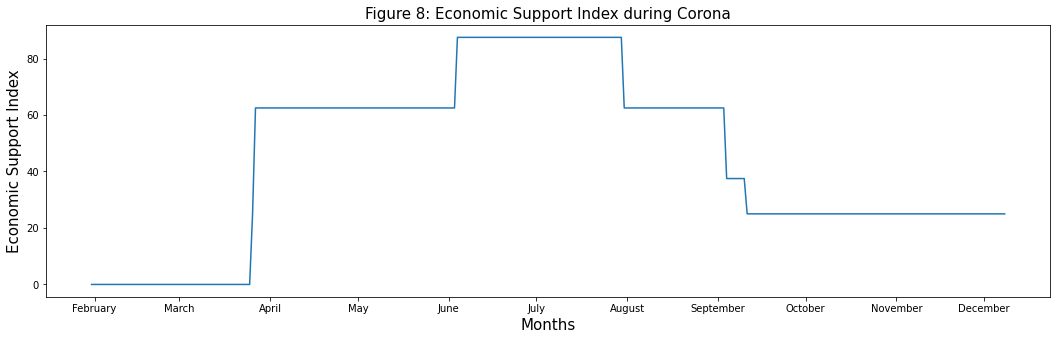

In [32]:
figure_8()

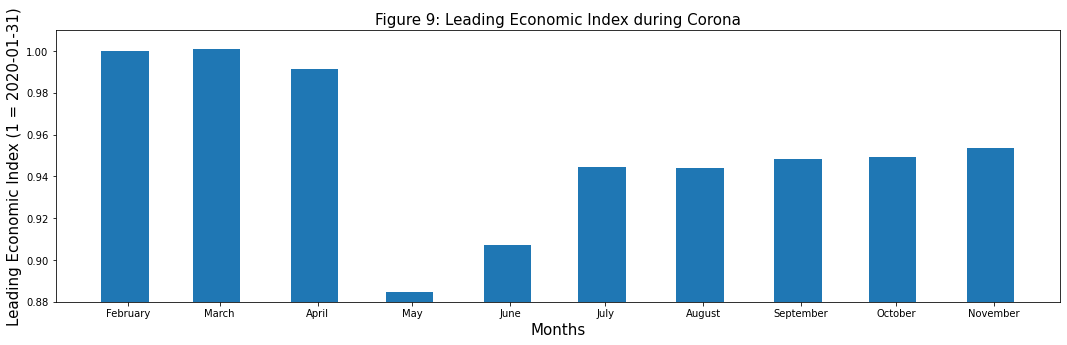

In [33]:
figure_9()

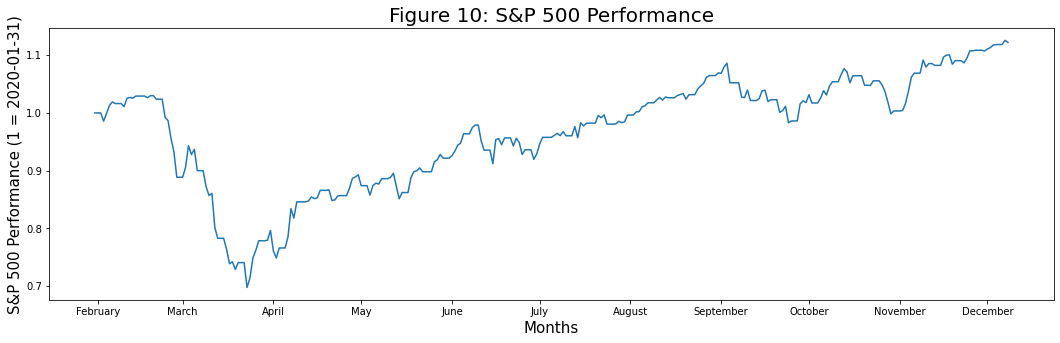

In [34]:
figure_10()

Figure 11 and 12 display the ESI plotted against both the S&P 500 and LEI performance. Figure 11 shows that the S&P 500 saw a rally at the same time as the economic support measures were put in place and continued to follow the same trend as the Economic Support Index until late summer 2020. Subsequently, when the intensity of economic support measures decreased, the S&P 500 stagnated until November, when news about potential [COVID-19 vaccines](https://www.bloomberg.com/graphics/covid-vaccine-tracker-global-distribution/) emerged, potentially explaining the rise toward the end of 2020 (Tracking the Coronavirus Vaccines That Will End the Pandemic 2020). This indicates that the economic support measures initially had a positive impact on stock market performance. Figure 12 paints an opposite picture for the relationship between the ESI and the LEI. Indeed, the Pearson correlation coefficient is -0.597, representing a strong negative correlation between the two. This implies that economic support measures had an adverse effect on the LEI. Both of the above would suggest that the economic support measures put in place by the government fail to effectively improve the livelihoods affected by the COVID-19 crisis economically, while propping up the stock market, thus failing to fulfil their objectives, and likely losing political support for similar programs in the future. 

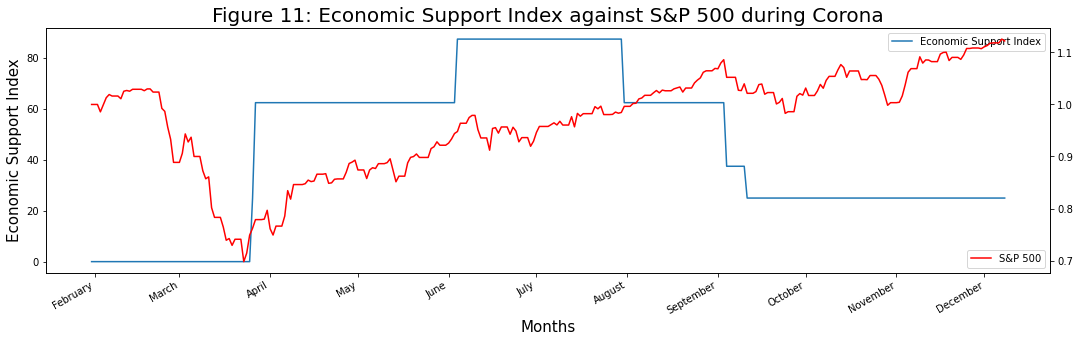

In [35]:
figure_11()

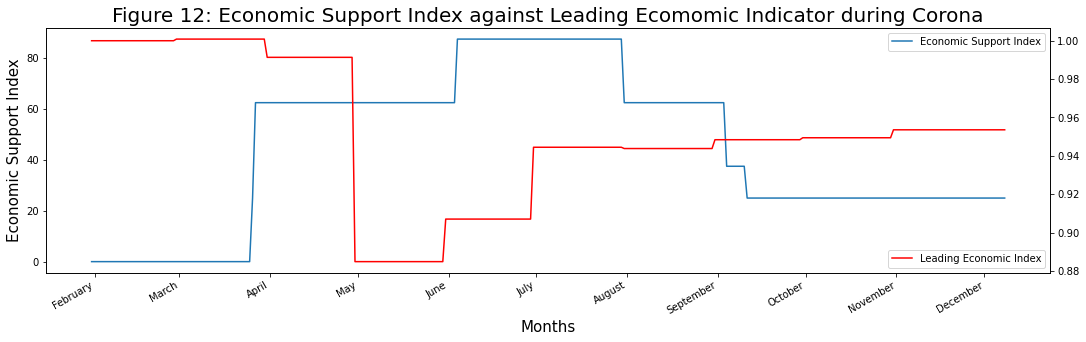

In [36]:
figure_12()

To further investigate the relationship between economic support measures and the LEI as well as the stock market, this paper continues to look at Figure 13 and 14. Figure 13 plots the ESI against the Federal Reserve balance sheet, disposable personal income, and unemployment. The first relation shows that during the increase of economic support measures, the Federal Reserve’s balance sheet rose as well, by up to 70% as compared to 31st January and staying at this level while the ESI decreases. This relationship will be further explored below. The second relationship shows that with a rise in the ESI disposable personal income rises as well, and vice versa for a fall in the ESI. Although there exist lagged effects, potentially due to red tape when channeling funds allocated via the economic support measures to individuals, the Pearson correlation coefficient for this relationship is 0.540, indicating a strong positive relationship. The third relationship in Figure 13 shows that unemployment rose fourfold in May 2020, likely due to national lockdown measures put in place. Nevertheless, the unemployment rate is recovering, albeit slowly, to a level twice as high as before the COVID-19 pandemic. As a result, this paper concludes that the economic support measures have had a likely positive effect on individuals’ livelihoods due to an overall increased level of disposable personal income, because this measure is more closely related to individuals’ lives than the LEI. Additionally, although unemployment increased dramatically, it recovered quickly, possibly due to strong consumer spending, which, in turn, has been strengthened by economic support measures.

Figure 14 sheds further light onto more nuanced effects between economic support measures and the stock market. It becomes clear that the Federal Reserve balance sheet is highly correlated to stock market performance, with a Pearson correlation coefficient of 0.442. 

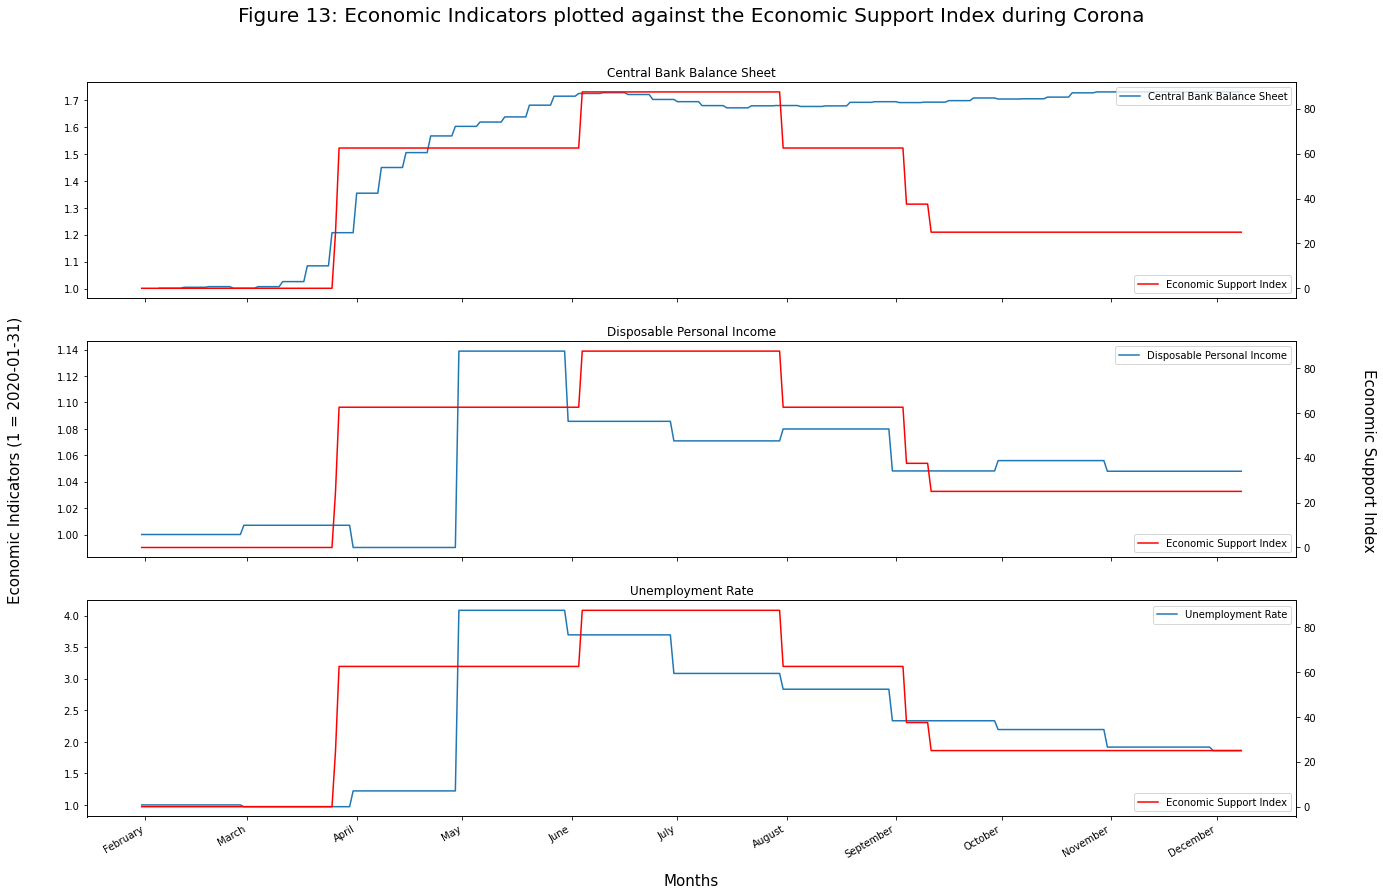

In [37]:
figure_13()

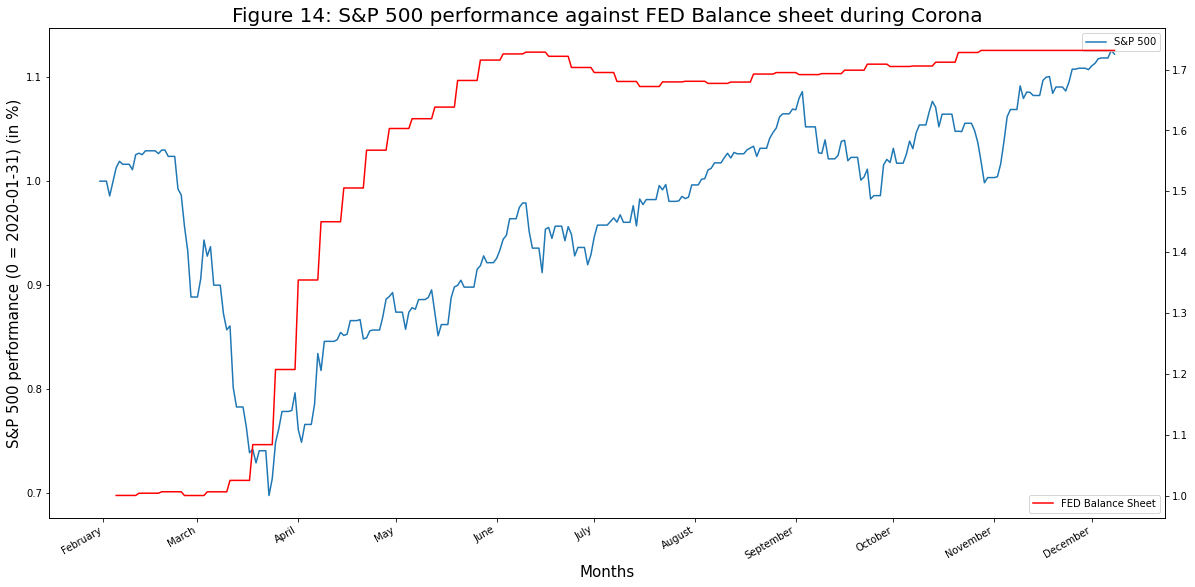

In [38]:
figure_14()

Motivated by the strong correlation observed in Figure 14, this paper further investigates several arguments for why the economic support measures could not have had a pronounced positive effect on the stock market performance. First, the stock market only values individual companies from many different sectors, where [performance differs vastly within and across sectors](https://www.mckinsey.com/business-functions/strategy-and-corporate-finance/our-insights/wall-street-versus-main-street-why-the-disconnect#) (Goedhart, Koller, Stumpner 2020). As portrayed in Figure 15, companies in the energy, utilities and real estate sector have suffered losses as compared to the 31st January 2020. Those sectors are also most likely to reflect the status of the real economic development alongside consumer staples and discretionary which saw moderate gains in line with the increased disposable personal income observed above. On the other hand, communication services and technology stocks have gained significantly, while not being representative of real economic development and also having an oversized effect on the overall composite. Consequently, the stock market’s aggregate value remained resilient albeit the COVID-19 induced economic downturn. Second, the market value of listed companies does not reflect the real economy. Many of the construction, professional-services firms, gyms, hairdressers, hospitals, restaurants, and other service businesses that generate the bulk of jobs and contribute materially to real economic indicators, such as the LEI, are not listed. As a result, the overall stock market can do relatively well even when the LEI is depressed. Both of the above points argue in favor of a disconnect between the economic support measures and the stock market performance, leading this paper to argue that rather the increased Federal Reserve balance sheet instead of increases in the ESI led to a market rally during the COVID-19 pandemic. 

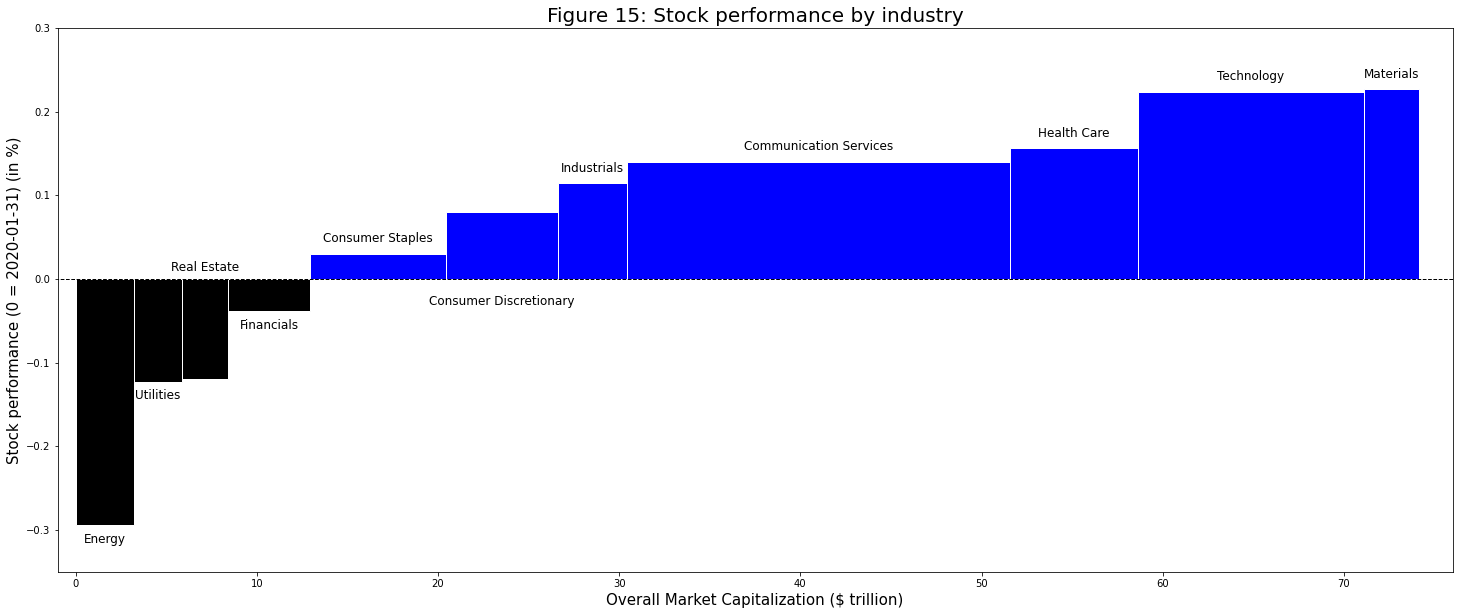

In [39]:
figure_15()

All in all, the paper arrives at the conclusion that the economic support measures put in place by the US government have had a lagged positive effect on real economic measures, such as the LEI, through increased consumer spending and a fast recovery of the unemployment rate, and only a limited to no effect on the stock market performance. As a result, the economic support measures are likely to win political support again, as they have had their desired effect, i.e., positively affecting the livelihoods of individuals in the United States while not provoking resentment against big corporates, as represented in the S&P 500.

# Part 2 Limitations

While conclusions about the relationship between the ESI and the LEI and S&P 500 can be drawn, two things remain to be investigated. First, it remains to be investigated what the effect of an increase in the Federal Reserve balance sheet means for the real economy. It could be the case that an increase in the balance sheet has a positive effect on real economic indicators as well, thus confounding the effect of the economic support measures on the economy. Second, it remains unclear how equal the effects of the ESI on disposable personal income are. Already, it has been noted that [higher-paid workers have the ability to work from home](https://www.weforum.org/agenda/2020/10/covid-19-is-increasing-multiple-kinds-of-inequality-here-s-what-we-can-do-about-it/), thus not suffering a slump in income and/or losing their job, while lower-paid blue-collar workers typically do not have this option (Goldin, Muggah 2020).

# References

Adam Mahdi, Piotr Błaszczyk, Paweł Dłotko, Dario Salvi, Tak-Shing Chan, John Harvey, Davide Gurnari, Yue Wu, Ahmad Farhat, Niklas Hellmer, Alexander Zarebski, Bernie Hogan, Lionel Tarassenko, Oxford COVID-19 Database: a multimodal data repository for better understanding the global impact of COVID-19.University of Oxford, 2020. medRxiv (doi: https://doi.org/10.1101/2020.08.18.20177147).

CARES Act Overview, 2020, Reed Smith, accessed 7 December 2020, <https://www.reedsmith.com/en/perspectives/2020/03/cares-act-overview>

Coronavirus Riskiest Activities, 2020, Information Is Beautiful, accessed 7 December 2020, <https://informationisbeautiful.net/visualizations/covid-19-coronavirus-infographic-datapack/>

Goedhart M, Koller T, Stumpner P, 2020, Wall Street versus Main Street: Why the disconnect?, McKinsey & Company, accessed 7 December 2020, <https://www.mckinsey.com/business-functions/strategy-and-corporate-finance/our-insights/wall-street-versus-main-street-why-the-disconnect#>

Goldin I, Muggah R, 2020, COVID-19 is increasing multiple kinds of inequality. Here's what we can do about it, 2020, World Economic Forum, accessed 7 December 2020, <https://www.weforum.org/agenda/2020/10/covid-19-is-increasing-multiple-kinds-of-inequality-here-s-what-we-can-do-about-it/>

Health Topics, 2020, World Health Organization, accessed 7 December 2020, <https://www.who.int/health-topics/coronavirus#tab=tab_1>

HDE, 2020, Market share of online trade in food sales in Germany from 2015 to 2019. In Statista. accessed 8 December 2020, <https://www.statista.com/statistics/993637/market-share-online-trade-food-sales-germany/>

Indicators, 2020, trading Economics, accessed 4 December 2020, <https://tradingeconomics.com/indicators>

Kitchings A, 2020, A Closer Look at the Conference Board Leading Economic Index, accessed 7 December 2020, <https://blog.commonwealth.com/independent-market-observer/a-closer-look-at-the-conference-board-leading-economic-index>

Policy Responses To COVID-19, 2020, Inernational Monetary Fund, accessed 7 Decmber 2020, <https://www.imf.org/en/Topics/imf-and-covid19/Policy-Responses-to-COVID-19#U>

S&P 500 Companies with Financial Information, 2020, Data Hub, accessed 4 December 2020, <https://datahub.io/core/s-and-p-500-companies-financials>

The market v the real economy, 2020, The Economist, accessed 7 December 2020, <https://www.economist.com/leaders/2020/05/07/the-market-v-the-real-economy>

Tracking the Coronavirus Vaccines That Will End the Pandemic, 2020, Bloomberg, accessed 7 December 2020, <https://www.bloomberg.com/graphics/covid-vaccine-tracker-global-distribution/>

Yahoo Finance API Documentation, 2020, Rapid API, accessed 4 December 2020, <https://rapidapi.com/apidojo/api/yahoo-finance1?endpoint=apiendpoint_aeccfc9c-66eb-4f4a-abf5-c14d952e09f6>

# Appendix

In [14]:
# displaying dataframes of best subset selected linear regression models
display(models_best)
print("Table 1: Dataframes of best subset selected linear regression models per category and number of parameters.")

,# Parameters,Parameters,R-squared
Dependent Variable,,,
Parks,1,temperature_mean_avg,0.872188
Parks,2,temperature_mean_avg,0.900473
Parks,2,windspeed_mean_avg,0.900473
Parks,3,precipitation_mean_avg,0.914207
Parks,3,temperature_mean_avg,0.914207
Parks,3,windspeed_mean_avg,0.914207
Grocery and Pharmacy,1,temperature_mean_avg,0.000044
Grocery and Pharmacy,2,stringency_index,0.072494
Grocery and Pharmacy,2,containment_health_index,0.072494


Table 1: Dataframes of best subset selected linear regression models per category and number of parameters.


<img src="figure6.pdf">

# Word Count

In [41]:
from notebook import notebookapp
import urllib
import json
import os
import ipykernel
import io
from IPython.nbformat import current

def notebook_path():
    
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+
                    'api/sessions?token='+srv['token'])
            
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],
                                        sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
    return None

with io.open(notebook_path(), 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        if cell['source'][:12] == "# References":
            continue
        else:
            word_count += len(cell['source'].replace('#','')
                              .lstrip().split(' '))

print(f"The word count, excluding references, is {word_count}")

The word count, excluding references, is 3466
